# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будем использовать данные с параметрами добычи и очистки. 
Модель должна помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


#### Ход исследования

- исследование предоставленных данных
- анализ и подготовка данных к обучению
- создадим, обучим несколько моделей (pipeline)
- выберем лучшую проверим на тестовой выборке и сравним результат с dummy моделью



#### Итоговый вывод:

Проведено исследование данных технологического процесса получения золота из руды.

Исходные данные за 2016-2018 года.
Выборки для теста и обучения были разделены заранее по месяцам, для получения качественных данных необходима стратификация, чтобы исключить влияния сезонности на результат.
Данные не обработанные содержат небольшое количество выбросов
Также данные содержат пропуски, которые были заполнены методом "k ближайших соседей"

Для вычисления качества модели, предложено использовать метрику SMAPE

Результат работы модели лучше чем dummy следовательно данную модель можно рекомендовать к применению

**Описание данных**

*Технологический процесс*

`Rougher feed` — исходное сырье\
`Rougher additions` (или `reagent additions`) — флотационные реагенты: `Xanthate`, `Sulphate`, `Depressant`\
`Xanthate` — ксантогенат (промотер, или активатор флотации);\
`Sulphate` — сульфат (на данном производстве сульфид натрия);\
`Depressant` — депрессант (силикат натрия).\
`Rougher process` (англ. «грубый процесс») — флотация\
`Rougher tails` — отвальные хвосты\
`Float banks` — флотационная установка\
`Cleaner process` — очистка\
`Rougher Au` — черновой концентрат золота\
`Final Au` — финальный концентрат золота

*Параметры этапов*\
`air amount` — объём воздуха\
`fluid levels` — уровень жидкости\
`feed size` — размер гранул сырья\
`feed rate` — скорость подачи

*Наименование признаков*\
Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`\
Пример: `rougher.input.feed_ag`

Возможные значения для блока [этап]:\
`rougher` — флотация\
`primary_cleaner` — первичная очистка\
`secondary_cleaner` — вторичная очистка\
`final` — финальные характеристики

Возможные значения для блока [тип_параметра]:\
`input` — параметры сырья\
`output` — параметры продукта\
`state` — параметры, характеризующие текущее состояние этапа\
`calculation` — расчётные характеристики

## Подготовка данных

Загрузим необходимые библиотеки

In [2]:
import os # Для выбора пути к дф
import re # Регулярные выражения для переименования
from IPython.display import display

from joblib import dump

import numpy as np

import pandas as pd
pd.set_option('max_colwidth', 100)
pd.set_option('display.width', 1080)

#!pip install plotly==5.5.0 # Для тренажера, если будет ошибка textauto в heatmap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.dummy import DummyRegressor # алгоритм классификации - Ванга
from sklearn.ensemble import RandomForestRegressor # алгоритм классификации - Лес случайных деревьев

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV

from sklearn.impute import KNNImputer # Заполнение пропусков на основе k-близжайших соседей
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression # алгоритм классификации - Логистическая регрессия
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNetCV

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV # Случайный перебор параметров модели
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split # Разбиение по выборкам

from sklearn.pipeline import make_pipeline # Создание трубопровода
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler # Масштабирование признаков более продвинуто с выбросами в данных
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle # Миксер

#!pip install catboost
from catboost import CatBoostRegressor

import sweetviz as sv
from pandas_profiling import ProfileReport
#!pip install pandas_profiling #https://github.com/pandas-profiling/pandas-profiling/archive/master.zip # Если ошибка в pandas_profiling
#import pandas_profiling
#from pandas_profiling import ProfileReport

Загрузим данные

In [3]:
pth1 = '/content/drive/MyDrive/data/gold_recovery_train_new.csv'
pth2 = '/content/drive/MyDrive/data/gold_recovery_test_new.csv'
pth3 = '/content/drive/MyDrive/data/gold_recovery_full_new.csv'
pth4 = 'gold_recovery_train_new.csv'
pth5 = 'gold_recovery_test_new.csv'
pth6 = 'gold_recovery_full_new.csv'

if os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3):
    train = pd.read_csv(pth1)
    test = pd.read_csv(pth2)
    full = pd.read_csv(pth3)
    print("Датасет успешно загружен с Google Disc")
elif os.path.exists(pth4) and os.path.exists(pth5) and os.path.exists(pth6):
    train = pd.read_csv(pth4)
    test = pd.read_csv(pth5)
    full = pd.read_csv(pth6)
    print("Датасет успешно загружен с ЯндексПрактикум")
else:
    print("Проверьте правильность пути к датасету")

all = [train, test, full]

Датасет успешно загружен с ЯндексПрактикум


In [4]:
for i in all:
    i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Изучим данные

In [5]:
for i in all:
    print(i.shape)

(14149, 87)
(5290, 53)
(19439, 87)


In [6]:
full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Преобразуем значения даты времени и округлим до ближайшего часа. В дальнейшем эта колонка нам понадобиться только для построения графиков

In [7]:
for i in all:
    i['date'] = pd.to_datetime(i['date']).dt.ceil('h')

In [8]:
full['date'].min(), full['date'].max()

(Timestamp('2016-01-15 00:00:00'), Timestamp('2018-08-18 11:00:00'))

In [9]:
profile = ProfileReport(train, minimal=True)
profile.to_file('test.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 25.32it/s]


In [10]:

profile = ProfileReport(train, minimal=True)
profile.to_file('train.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчётами и значением признака

In [11]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']
r = train['rougher.output.recovery']


recovery = ((c*(f-t))/(f*(c-t)))*100
abs(recovery - r).mean()

9.73512347450521e-15

Эффективность расчитана верно

Проанализируем признаки, недоступные в тестовой выборке

In [12]:
train_test_diff = []
for i in train.columns:
    if i not in test.columns:
        train_test_diff.append(i)
train_test_diff

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Часть параметров `calculation` - расчетные, остальные `output` - характеристики продукта, получают позднее скорее всего после исследования образцов

**Вывод:**
Предварительно ознакомившись с данными установили, что данные представлены в виде трех датасетов основной full и два выделенных из него train и test. Разбиение подготовлено для обучения модели.

Всего используется 19439 значений на каждое 87 признаков

В данных встречаются выбросы и пропуски.

Столбец с датой и временем преобразован в удобный для исследования формат.

## Анализ данных

Посмотрим как распределены два одинаковых столбца в выборке train и test

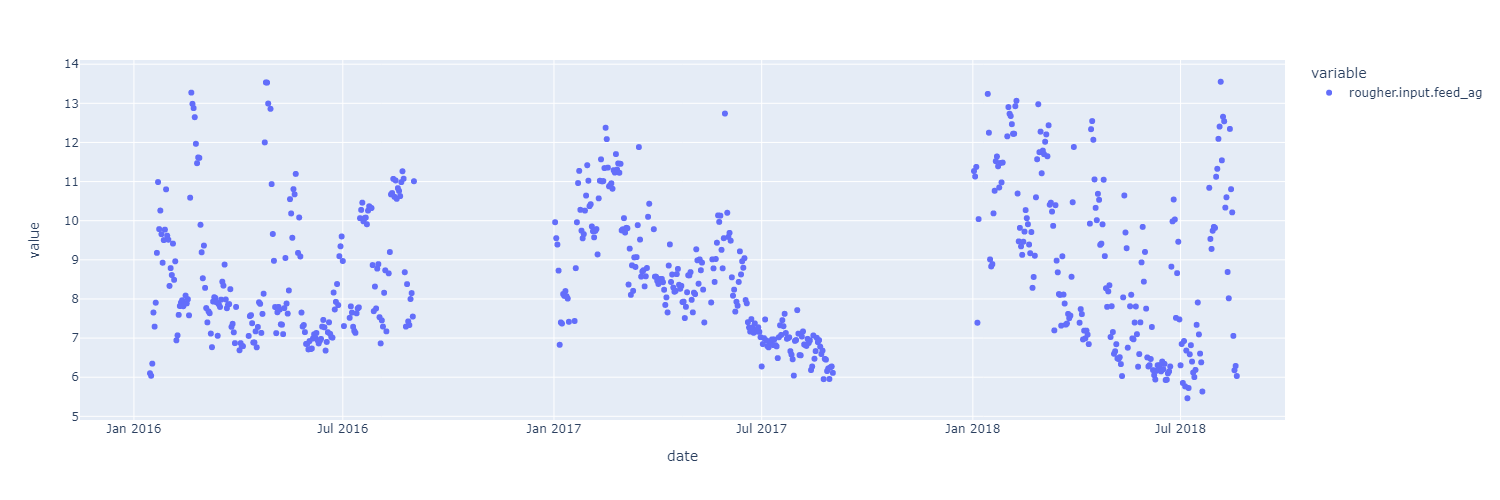

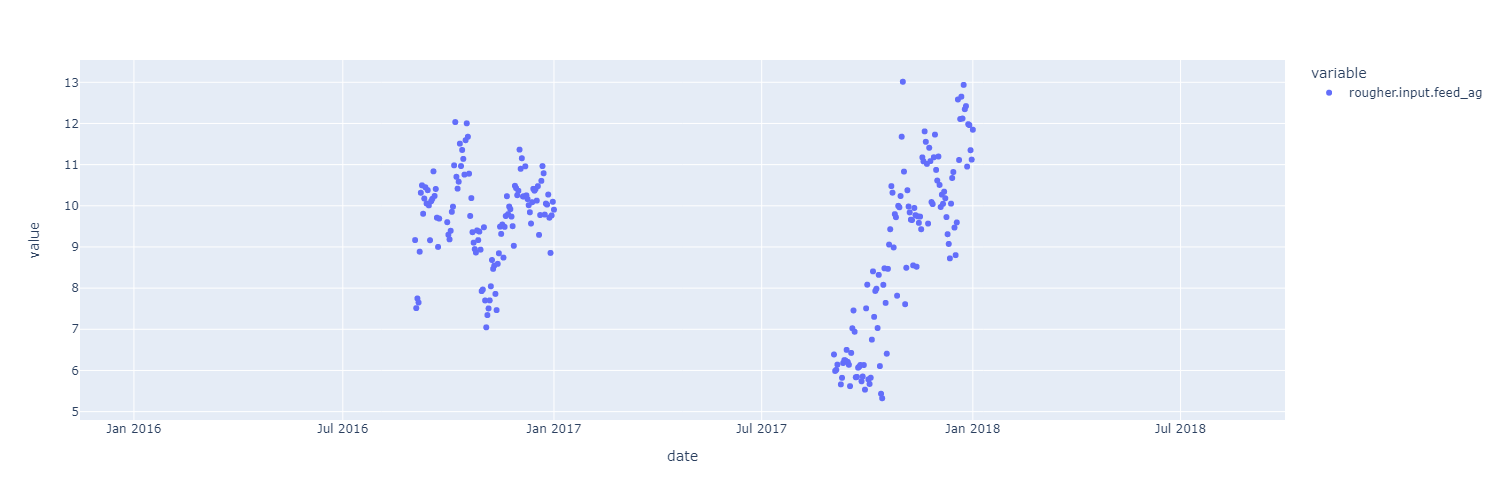

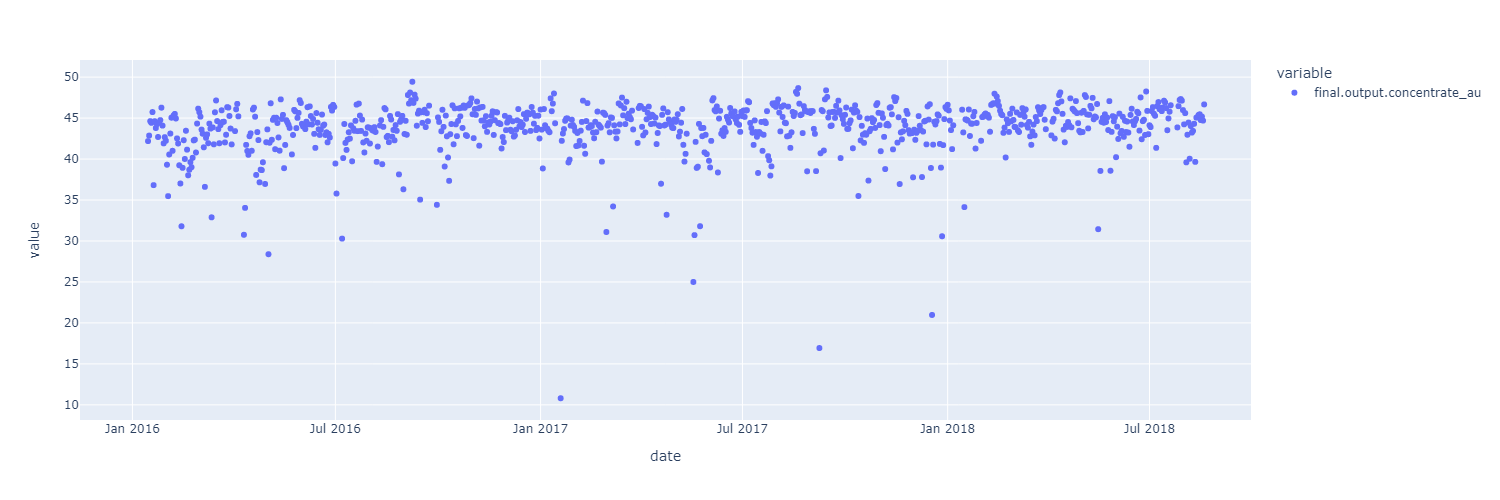

In [13]:
train_piv = train.pivot_table(index=train['date'].dt.ceil('d'), values="rougher.input.feed_ag")
train_piv.reset_index()

fig = px.scatter(train_piv, range_x=['2015-11-15', '2018-09-30'])
fig.update_layout(width=1500, height=500)
fig.show('png')

test_piv = test.pivot_table(index=test['date'].dt.ceil('d'), values="rougher.input.feed_ag")
test_piv.reset_index()

fig = px.scatter(test_piv, range_x=['2015-11-15', '2018-09-30'])
fig.update_layout(width=1500, height=500)
fig.show('png')

full_piv = full.pivot_table(index=full['date'].dt.ceil('d'), values="final.output.concentrate_au")
full.reset_index()

fig = px.scatter(full_piv, range_x=['2015-11-15', '2018-09-30'])
fig.update_layout(width=1500, height=500)
fig.show('png')

Данные тестовой выборки сформированы двумя дипазонами по датам. Из-за не равномерности распределения некоторых данных, желательно использовать стратифицированную выборку. При этом финальная концентрация стабильна на протяжении всего времени измерений

In [14]:
train.groupby(train['date'].dt.strftime('%Y-%m'))['rougher.input.feed_ag'].count()  

date
2016-01    350
2016-02    672
2016-03    594
2016-04    399
2016-05    676
2016-06    701
2016-07    600
2016-08    689
2016-09      1
2017-01    581
2017-02    617
2017-03    643
2017-04    702
2017-05    454
2017-06    680
2017-07    700
2017-08    710
2017-09      1
2018-01    306
2018-02    606
2018-03    646
2018-04    630
2018-05    646
2018-06    648
2018-07    546
2018-08    351
Name: rougher.input.feed_ag, dtype: int64

In [15]:
test.groupby(test['date'].dt.strftime('%Y-%m'))['rougher.input.feed_ag'].count()

date
2016-09    495
2016-10    725
2016-11    680
2016-12    719
2017-01      1
2017-09    609
2017-10    686
2017-11    696
2017-12    678
2018-01      1
Name: rougher.input.feed_ag, dtype: int64

Данные замеров поступают не равномерно, единичные замеры образовались из-за округления данных

Построим графики распределения концентрации металлов на различных этапах очистки

In [16]:
def ploting_displot(met):
    df = full[['rougher.input.feed_' + str(met),
                'rougher.output.concentrate_' + str(met), 
                'primary_cleaner.output.concentrate_' + str(met), 
                'final.output.concentrate_' + str(met)]]
    for col in df.columns:
        plt = df[col].hist(bins=100, alpha=0.7, figsize=(10,4))
        plt.set_xlabel('Концентрация')
        plt.set_ylabel('Частота')
        plt.set_title(met) 
       # не в plotly так как лаги, и request size error из-за объема данных

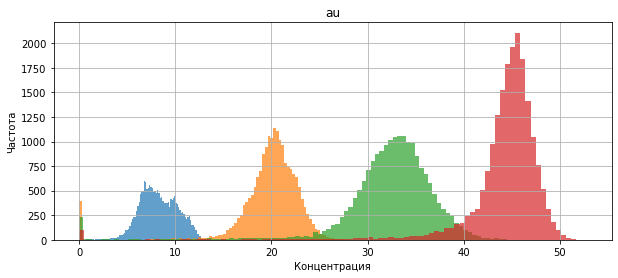

In [17]:
ploting_displot('au')

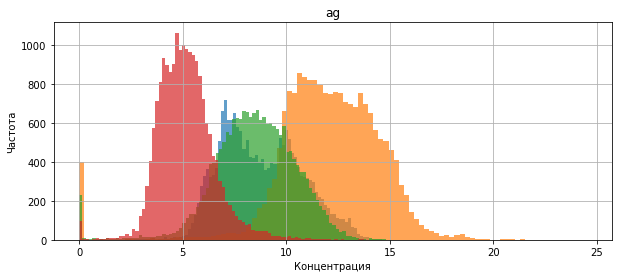

In [18]:
ploting_displot('ag')

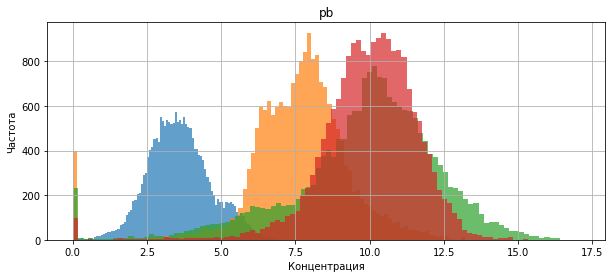

In [19]:
ploting_displot('pb')

Концентрация свинца после первого этапа не снижается, и остальные этапы не сильно влияют на него\
Концентрация серебра сначала повышается а затем снижается на каждой стадии\
Концентрация как и предполагается растет на каждом этапе

Видим часть данных с 0. Судя по распределению похоже на ошибку. 

Распределение размера зерна

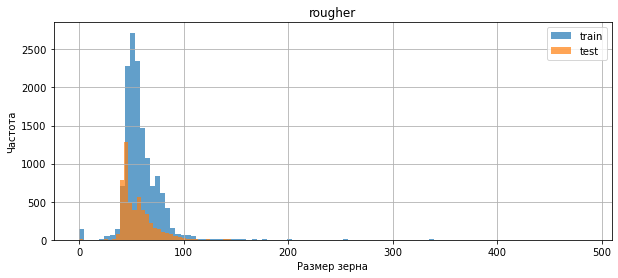

In [20]:
plt = train['rougher.input.feed_size'].fillna(0).hist(bins=100, alpha=0.7, figsize=(10,4))
plt = test['rougher.input.feed_size'].fillna(0).hist(bins=100, alpha=0.7, figsize=(10,4))
plt.set_xlabel('Размер зерна')
plt.set_ylabel('Частота')
plt.set_title('rougher')
plt.legend(['train', 'test']);

In [21]:
abs(train['rougher.input.feed_size'] - test['rougher.input.feed_size']).median()

10.387637036645678

Разница довольно велика. Дополнительно проведем тест Колмогорова-Смирнова для двух распределений. Примем нулевую гипотезу что данные выборки `test` и `train` взяты из одной выборки. Примем уровень значимости 95%. Следовательно p-value = 0.05

In [22]:
from scipy.stats import ks_2samp

ks_2samp(train['rougher.input.feed_size'], test['rougher.input.feed_size'], alternative='two-sided')

KstestResult(statistic=0.2505820112464947, pvalue=1.692354628798114e-213)

Тест отвергает нулевую гипотезу о том что данные взяты из одного распределения.

Данные о размерах зерен значительно отличаются для тренировочной и тестовой выборки, что в худшую сторону повлияет на качество модели

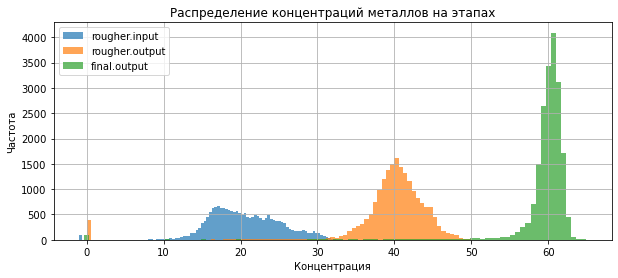

In [23]:
df = pd.DataFrame()

df['rougher.input'] = full['rougher.input.feed_pb'] + \
                      full['rougher.input.feed_au'] + \
                      full['rougher.input.feed_ag']

df['rougher.output'] = full['rougher.output.concentrate_pb'] + \
                       full['rougher.output.concentrate_au'] + \
                       full['rougher.output.concentrate_ag']

df['final.output'] = full['final.output.concentrate_pb'] + \
                     full['final.output.concentrate_au'] + \
                     full['final.output.concentrate_ag']

df = df.fillna(-1)

for col in df.columns:
    plt = df[col].hist(bins=100, alpha=0.7, figsize=(10,4))
    
plt.set_xlabel('Концентрация')
plt.set_ylabel('Частота')
plt.set_title('Распределение концентраций металлов на этапах')
plt.legend(['rougher.input', 'rougher.output', 'final.output']);

In [24]:
train.shape

(14149, 87)

In [25]:
metalls=['au', 'ag', 'pb']                    
for met in metalls:      
    train = train[train['rougher.input.feed_' + str(met)]>1]
    train = train[train['rougher.output.concentrate_' + str(met)]>1]
    train = train[train['final.output.concentrate_' + str(met)]>1]

In [26]:
train.shape

(13580, 87)

In [27]:
train[train['rougher.input.feed_pb']<1]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


Подготовим функцию расчета метрики качества, и сделаем scorer

In [28]:
def smape(y, y_pred):
    return (1 / len(y) * sum(abs(y - y_pred) * 2 / (abs(y) + abs(y_pred)))) * 100


def smape_final(rougher, final):
    return 0.25*rougher + 0.75*final

smape_scorer = make_scorer(smape, greater_is_better=False)

Проверим на пропуски по столбцам

In [29]:
full.isna().sum().sort_values(ascending=False).head(20)

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
final.output.concentrate_sol                 211
rougher.input.feed_size                      145
primary_cleaner.output.concentrate_pb        116
primary_cleaner.input.xanthate               104
final.output.tail_pb                         101
rougher.input.feed_pb                        100
rougher.input.feed_sol                        99
primary_cleaner.output.tail_sol               62
rougher.input.floatbank11_sulfate             44
primary_cleaner.input.depressant              37
rougher.input.floatbank10_sulfate             34
primary_cleaner.input.sulfate                 24
rougher.output.concentrate_sol                23
secondary_cleaner.state.floatbank2_b_air      23
primary_cleaner.output.tail_pb                21
dtype: int64

Пропуски заполним на этапе работы модели

Выберем столбцы с сильной корреляцией, которые могут помешать работе модели

In [30]:
corr_feat = set()
corr_matrix = train.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)
corr_feat

{'primary_cleaner.output.tail_pb',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.input.feed_au',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.state.floatbank4_b_air',
 'secondary_cleaner.state.floatbank5_a_air',
 'secondary_cleaner.state.floatbank5_b_air',
 'secondary_cleaner.state.floatbank5_b_level'}

Похоже, что в столбцах floatbank указаны данные для разных резервуаров для одного технологического процесса

Добавим столбцы которыми отличаются в выборках `train` и `test`

In [31]:
train_test_diff_delcorr = train_test_diff + list(corr_feat)

И столбец с датой

In [32]:
train_test_diff_delcorr.append('date')

Перемешаем обучающую выборку

In [33]:
train = shuffle(train, random_state=47)

**Вывод**
Данные проанализированы и подготовлены к обучению модели. Пропуски будут заполнены моделью.

Сильно коррелирующие признаки удалены.

Размер зерен значительно отличается на тестовой и тренировочной выборке, что в худшую сторону повлияет на качество модели

## Модель

Разобьем данные и подготовим столбцы для обучения модели

In [34]:
X_train = train.drop(train_test_diff_delcorr, axis=1)
y_train_rougher = train['rougher.output.recovery']
y_train_final = train['final.output.recovery']

X_test = test.drop(train_test_diff_delcorr, axis=1, errors='ignore')
y_test_rougher = test.merge(
    full[['date', 'rougher.output.recovery']], 
    on='date', 
    how='inner')['rougher.output.recovery']
y_test_final = test.merge(
    full[['date', 'final.output.recovery']], 
    on='date', 
    how='inner')['final.output.recovery']


print('Тренировочная выборка:', X_train.shape)
print('Среднее в тренировочной выборке для rougher:', round(y_train_rougher.mean(), 2))
print('Среднее в тренировочной выборке для final:', round(y_train_final.mean(), 2))
print(' * '*3)
print('Тестовая выборка:', X_test.shape)
print('Среднее в тестовой выборке для rougher:', round(y_test_rougher.mean(), 2))
print('Среднее в тестовой выборке для final:', round(y_test_final.mean(), 2))
print(' * '*3)
print('Отношение train/test:', round(len(X_test)/len(X_train), 2))

Тренировочная выборка: (13580, 32)
Среднее в тренировочной выборке для rougher: 84.61
Среднее в тренировочной выборке для final: 66.96
 *  *  * 
Тестовая выборка: (5290, 32)
Среднее в тестовой выборке для rougher: 85.0
Среднее в тестовой выборке для final: 68.47
 *  *  * 
Отношение train/test: 0.39


In [35]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer()), # KNNImputer логичнее, так как рядом стоящие значения похожи, но он сломался
        ("scaler", MinMaxScaler()),
        ("regressor", CatBoostRegressor())
    ]
)

param_grid = [
    {
        'regressor': [CatBoostRegressor(random_state=47, silent=True)],
        'regressor__depth': [6, 8, 10],
        'regressor__learning_rate': [0.03, 0.1, 1],
        'regressor__iterations': [50, 100]
    },
    {
        'regressor': [Lasso(random_state=47)],
        'regressor__alpha': [0.1, 0.5, 1],
        'regressor__tol': [0.001, 0.01, 0.1],
        'regressor__max_iter': [100000, 1000000]
    }
]

grid = RandomizedSearchCV(pipe, param_grid, n_iter=50 ,cv=5, scoring = smape_scorer, verbose=3)

In [36]:
%%time
grid.fit(X_train, y_train_rougher)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\s7\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning:

The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.



[CV 1/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-4.564 total time=   1.2s
[CV 2/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-4.506 total time=   1.0s
[CV 3/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-4.323 total time=   0.8s
[CV 4/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-4.256 total time=   0.7s
[CV 5/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-4.307 total time=   0.7s
[CV 1/5] END re

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', MinMaxScaler()),
                                             ('regressor',
                                              <catboost.core.CatBoostRegressor object at 0x0000022594EFFA90>)]),
                   n_iter=50,
                   param_distributions=[{'regressor': [<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>],
                                         'regressor__depth': [6, 8, 10],
                                         'regressor__iterations': [50, 100],
                                         'regressor__learning_rate': [0.03, 0.1,
                                                                      1]},
                                        {'regressor': [Lasso(random_state=47)],
                                         'regressor__alpha': [0.1, 0.5, 1],
                                         'regressor__max_iter': [100000,
                                                                 1000000],
                                         'regressor__tol': [0.001, 0.01, 0.1]}],
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=3)

In [37]:
result = pd.DataFrame(grid.cv_results_)
result.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__learning_rate,param_regressor__iterations,param_regressor__depth,param_regressor,param_regressor__tol,param_regressor__max_iter,param_regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,13.235796,1.203236,0.007398,0.000799,0.1,100,10,<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>,NaN,NaN,NaN,"{'regressor__learning_rate': 0.1, 'regressor__iterations': 100, 'regressor__depth': 10, 'regress...",-2.916036,-2.906414,-2.819315,-2.697357,-2.812324,-2.830289,0.079071,1
10,3.447902,0.393621,0.014900,0.015564,0.1,100,8,<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>,NaN,NaN,NaN,"{'regressor__learning_rate': 0.1, 'regressor__iterations': 100, 'regressor__depth': 8, 'regresso...",-3.126020,-3.088229,-3.031558,-2.915066,-3.001442,-3.032463,0.072949,2
13,6.273825,0.059347,0.007402,0.000804,0.1,50,10,<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>,NaN,NaN,NaN,"{'regressor__learning_rate': 0.1, 'regressor__iterations': 50, 'regressor__depth': 10, 'regresso...",-3.236387,-3.258109,-3.108451,-3.035309,-3.130002,-3.153652,0.082902,3
4,1.469468,0.080624,0.006501,0.000630,0.1,100,6,<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>,NaN,NaN,NaN,"{'regressor__learning_rate': 0.1, 'regressor__iterations': 100, 'regressor__depth': 6, 'regresso...",-3.411090,-3.390088,-3.297437,-3.152202,-3.234608,-3.297085,0.096479,4
7,1.919797,0.084813,0.007997,0.000895,0.1,50,8,<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>,NaN,NaN,NaN,"{'regressor__learning_rate': 0.1, 'regressor__iterations': 50, 'regressor__depth': 8, 'regressor...",-3.461941,-3.471725,-3.348751,-3.237857,-3.328969,-3.369849,0.087633,5


In [38]:
print(grid.best_estimator_.named_steps.regressor)

Посмотрим наиболее важные параметры для модели

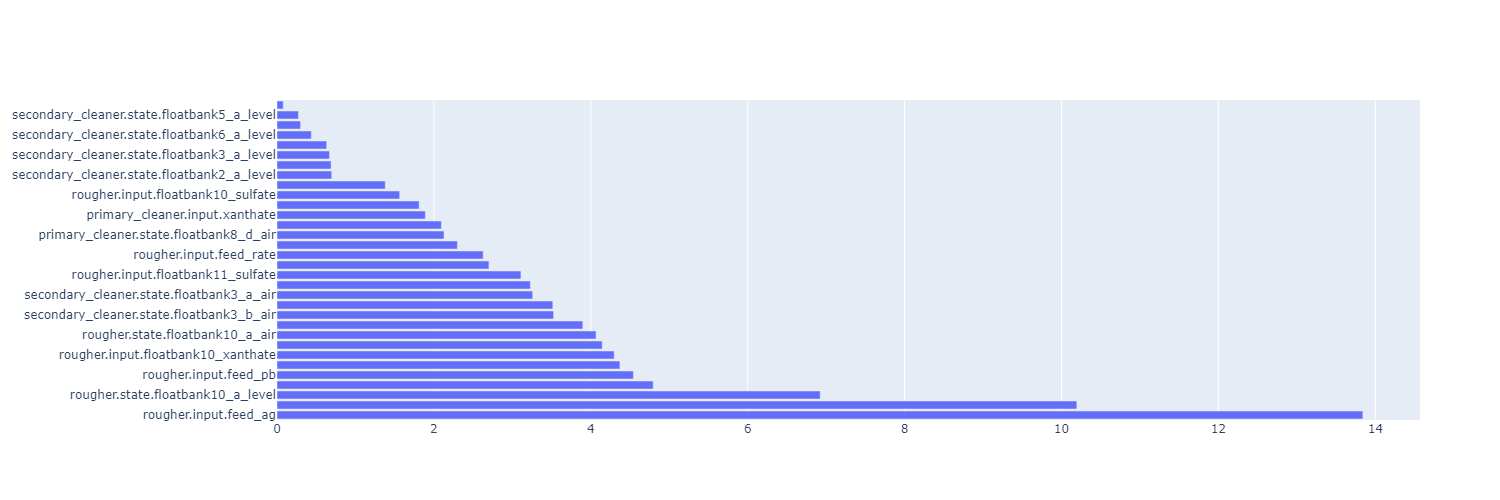

In [39]:
dset = pd.concat([pd.Series(X_train.columns), 
                  pd.Series(grid.best_estimator_.named_steps["regressor"].feature_importances_)], axis= 1 )
dset = dset.set_axis(['attr', 'importance'], 
                     axis=1, 
                     inplace=False).sort_values(by='importance', 
                                                ascending=False)
fig = go.Figure(go.Bar(
            x=dset["importance"],
            y=dset['attr'],
            orientation='h'))

fig.update_layout(width=1500, height=500)
fig.show('png')

Модель обучена, проверим ее работу на тестовой выборке

In [40]:
y_val_rougher = grid.best_estimator_.predict(X_test)

In [41]:
rougher_test_val = smape(y_val_rougher, 
                         y_test_rougher)
print('Результат работы модели для rougher, SMAPE:', round(rougher_test_val, 2), '%')

Результат работы модели для rougher, SMAPE: 8.06 %


Первая часть метрики получена, проведем ту же последовательность действий для `final`

In [42]:
%%time
grid.fit(X_train, y_train_final)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\s7\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning:

The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.



[CV 1/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-7.825 total time=   0.7s
[CV 2/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-7.687 total time=   0.8s
[CV 3/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-7.653 total time=   0.6s
[CV 4/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-7.129 total time=   0.7s
[CV 5/5] END regressor=<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>, regressor__depth=6, regressor__iterations=50, regressor__learning_rate=0.03;, score=-7.717 total time=   0.7s
[CV 1/5] END re

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', MinMaxScaler()),
                                             ('regressor',
                                              <catboost.core.CatBoostRegressor object at 0x0000022594EFFA90>)]),
                   n_iter=50,
                   param_distributions=[{'regressor': [<catboost.core.CatBoostRegressor object at 0x0000022594EFFBB0>],
                                         'regressor__depth': [6, 8, 10],
                                         'regressor__iterations': [50, 100],
                                         'regressor__learning_rate': [0.03, 0.1,
                                                                      1]},
                                        {'regressor': [Lasso(random_state=47)],
                                         'regressor__alpha': [0.1, 0.5, 1],
                                         'regressor__max_iter': [100000,
                                                                 1000000],
                                         'regressor__tol': [0.001, 0.01, 0.1]}],
                   scoring=make_scorer(smape, greater_is_better=False),
                   verbose=3)

In [43]:
y_val_final = grid.best_estimator_.predict(X_test)

In [44]:
final_test_val = smape(y_val_final, y_test_final)
print('Результат работы модели для final, SMAPE:', round(final_test_val, 2), '%')

Результат работы модели для final, SMAPE: 9.28 %


Считаем финальный результат

In [45]:
result = smape_final(rougher_test_val, final_test_val)
result

8.975886098493007

**Вывод:**

Проведено исследование данных технологического процесса получения золота из руды.

Исходные данные за 2016-2018 года.
Выборки для теста и обучения были разделены заранее по месяцам, для получения качественных данных необходима стратификация, чтобы исключить влияния сезонности на результат.
Данные не обработанные содержат небольшое количество выбросов
Также данные содержат пропуски, которые были заполнены методом "k ближайших соседей"

Для вычисления качества модели, предложено использовать метрику SMAPE


In [46]:
print('Итоговый результат отклонения модели составил:', round(result, 2), '%')

Итоговый результат отклонения модели составил: 8.98 %


Проверим модель на адекватность

In [47]:
dum_model = DummyRegressor(strategy="mean")
dum_model.fit(X_train, y_train_rougher)
dum_pred_rougher = dum_model.predict(X_test)

dum_model.fit(X_train, y_train_final)
dum_pred_final = dum_model.predict(X_test)

rougher = smape(y_test_rougher, dum_pred_rougher)
final = smape(y_test_final, dum_pred_final)

print("DummyRegressor на тестовой выборке:", round(smape_final(rougher, final), 3))

DummyRegressor на тестовой выборке: 9.754


In [48]:
print("Разница между DummyRegressor и нашей моделью:", round((smape_final(rougher, final) - result), 2))

Разница между DummyRegressor и нашей моделью: 0.78


Результат работы модели лучше чем dummy следовательно данную модель можно рекомендовать к применению